In [1]:
import copy
from core.datasets import FER13
from core.network import Fernet
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
%matplotlib inline

In [2]:
preprocess = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [3]:
datasets = {
    x: FER13(
        root = "./data",
        train = True if x == "train" else False,
        transform = preprocess,
    )
    for x in ["train", "val"]
}

In [4]:
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=1536,
        shuffle=False,
        num_workers=4
    )
    for x in ["train", "val"]
}
class_names = datasets["train"].classes
dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "val"]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_tracker = {
        'train': [],
        'val': [],
    }

    acc_tracker = {
        'train': [],
        'val': [],
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                labels = labels.type(torch.LongTensor)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_tracker[phase].append(epoch_loss)
            acc_tracker[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_tracker, acc_tracker

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
torch.manual_seed(0)
gray_model = Fernet()

gray_model = gray_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(gray_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=1)

In [8]:
gray_model, losses, accuracies = train_model(
    gray_model,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=10
)

Epoch 0/29
----------
train Loss: 1.7527 Acc: 0.2867
val Loss: 1.6720 Acc: 0.3383

Epoch 1/29
----------
train Loss: 1.6625 Acc: 0.3391
val Loss: 1.5789 Acc: 0.3814

Epoch 2/29
----------
train Loss: 1.6260 Acc: 0.3591
val Loss: 1.5580 Acc: 0.3867

Epoch 3/29
----------
train Loss: 1.5979 Acc: 0.3713
val Loss: 1.5421 Acc: 0.4023

Epoch 4/29
----------
train Loss: 1.5847 Acc: 0.3795
val Loss: 1.5453 Acc: 0.3881

Epoch 5/29
----------
train Loss: 1.5777 Acc: 0.3834
val Loss: 1.5544 Acc: 0.3901

Epoch 6/29
----------
train Loss: 1.5740 Acc: 0.3789
val Loss: 1.5537 Acc: 0.3870

Epoch 7/29
----------
train Loss: 1.5725 Acc: 0.3834
val Loss: 1.5112 Acc: 0.4101

Epoch 8/29
----------
train Loss: 1.5630 Acc: 0.3890
val Loss: 1.5284 Acc: 0.4163

Epoch 9/29
----------
train Loss: 1.5553 Acc: 0.3901
val Loss: 1.5158 Acc: 0.4001

Epoch 10/29
----------
train Loss: 1.4697 Acc: 0.4271
val Loss: 1.4203 Acc: 0.4486

Epoch 11/29
----------
train Loss: 1.4489 Acc: 0.4361
val Loss: 1.4257 Acc: 0.4539

Ep

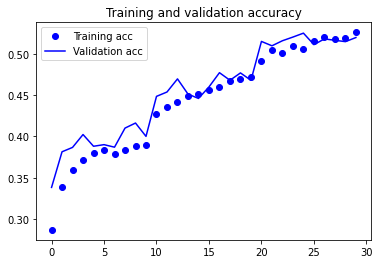

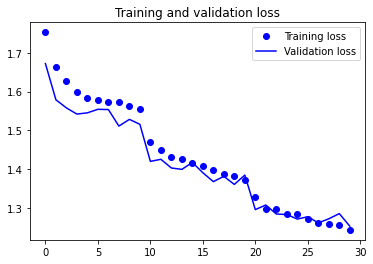

In [9]:
acc = accuracies['train']
val_acc = accuracies['val']
loss = losses['train']
val_loss = losses['val']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()